# Optimization Methods

In this section we will discuss optimization methods for machine learning. The optimization is the "learning" step in machine learning. There we fit the model to out data, eg. in neural network we will change weights, in linear regression we will change slope and intercept of the model by minimizing a loss function.

The content is only an overview about the optimization techniques and for further reading please look at

["INTRODUCTION TO STOCHASTIC SEARCH AND OPTIMIZATION"](https://printkr.hs-niederrhein.de:2173/doi/pdfdirect/10.1002/0471722138)  

by JAMES C. SPALL {cite}```Spall2003``` and

["Algorithms for Optimization"](https://algorithmsbook.com/optimization/files/optimization.pdf)  

by Mykel J. Kochenderfer and Tim A. Wheele {cite}```Kochenderfer2019```.



## Introduction: an easy example

We want to make a simple linear regression on given data below. For that we want to fit the parameter $\beta_0$ and $ \beta_1$ from the linear regession
$$y_i:=f(x_i)= \beta_0+\beta_1x_i $$

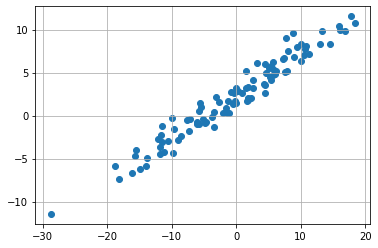

In [3]:
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
from matplotlib import cm

x = scipy.stats.norm.rvs(size=100)*10 # Data generation
y = 2.5 + 0.5 * x + scipy.stats.norm.rvs(size=100)

plt.scatter(x,y)
plt.grid()

We now make initial guess for parameters $\beta_0=1$ and $\beta_1 =1$ and see how our model performs. 

For that we need some measure how "good" our fit was. We calculate the difference of each point to our line and we want no negative value so we square the difference of these.

We will then get the `Residual Sum of Squares` (RSS):
$$RSS(\beta_0,\beta_1):=\sum_{i=1}^n(y_p-y)^2$$

Where $y_p$ is the prediction of our model and $y$ is the real data.


RSS of initial guess:  2554.6543498461815


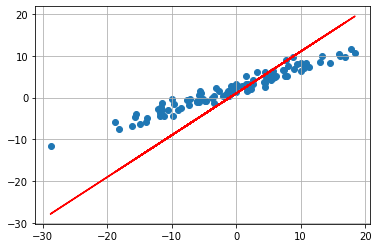

In [4]:
def RSS(beta):
    y_p = beta[0] + beta[1]*x
    return np.sum((y_p-y)**2)

beta0,beta1 = 1,1 #define initial guess

plt.scatter(x,y)
plt.grid()
y_p = beta0 + beta1*x
plt.plot(x,y_p,"r")

print("RSS of initial guess: ",RSS(np.array([beta0,beta1])))

We now see that our initial guess is not good at all. But we can now use the RSS to fit our function to the data. We are searching for a minimum of the RSS function. The coeficents which fits our data best are

$$(\hat{\beta}_0\hat{\beta}_1)=\argmin_{\beta_0,\beta_1}(RSS)$$

For this we can use the given solution in OLS section of the book. We could also use for example newton's method to solve this for us. Luckily `scipy.opimize.minimize` has a software for us.

RSS of optimum:  113.78434147186353


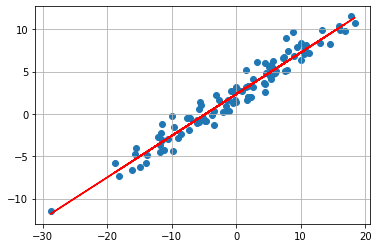

In [5]:
iters = []
start = np.array([1,1,RSS(np.array([1,1]))])
iters.append(start)
def callbackF(Xi):
    iterations = np.append(Xi,RSS(Xi))
    iters.append(iterations)

opt = scipy.optimize.minimize(RSS, x0=np.array([1,1]), args=(), method='TNC', callback=callbackF) #optimize using scipy implementation of truncated newton's method
iters= np.asarray(iters)

plt.scatter(x,y)
plt.grid()
y_p = opt.x[0] + opt.x[1]*x
plt.plot(x,y_p,"r")

print("RSS of optimum: ",RSS(np.array([opt.x[0],opt.x[1]])))

We now see that the "fit" of our model is much better. This method above falls under the category gradient optimization. However Newton's method is not often used in machine learning because we need the second derivative, which categorises this algorithm in higher order schemes. But often this is not possible or it is just to resource consuming to use it. For the newton's method we need to calculate a inverse of the hessian matrix to get better convergence than first order gradient descent methods.

Now let us take a look on what happend to the RSS function in our optimization algorithm. The next plot shows the start value and the iteration of the algorithm to find a minimum with the help of the gradient. 

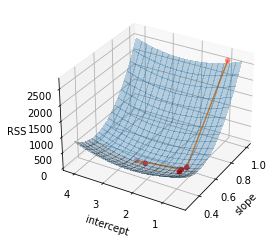

<Figure size 864x720 with 0 Axes>

In [6]:
intercept = opt.x[0]
slope = opt.x[1]
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.arange(-5, 5, 0.25) #slope
X = np.linspace(slope-0.2, slope+0.5, 20)
Y = np.arange(-5, 5, 0.25) #intercept
Y = np.linspace(intercept-1.8, intercept+1.8, 20)

rss_values_all = []
for slope_alt in np.linspace(slope-0.2, slope+0.5, 20):
    rss_values_x = []
    for intercept_alt in np.linspace(intercept-1.8, intercept+1.8, 20):
        rss_values_x.append(RSS(np.array([intercept_alt,slope_alt])))
    rss_values_all =  np.append(rss_values_all,rss_values_x,axis=0)

plt.figure(figsize=(12,10))
X, Y = np.meshgrid(X, Y)
Z = rss_values_all.reshape(20,20).T

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, linewidth=0, antialiased=False, alpha=0.3)
ax.set_xlabel('slope')
ax.set_ylabel('intercept')
ax.set_zlabel('RSS')
dots = ax.scatter3D(iters[:,1], iters[:,0], iters[:,2],s=20, c='r', marker='o') # ToDo add order of iterations
lines = ax.plot(iters[:,1], iters[:,0], iters[:,2]) 
ax.view_init(30, 210)
plt.show()

## Benchmark Problems
In the next part we will look on different optimization algorithm and how they perform on various problems. Not all problems are that easy to solve that we done above. We will take a look on some benchmark problems.

We will look at the Rosenbrock function in 2d

$$f(x,y) = (a-x)^2+b(y-x^2)^2 $$

with usually parameters $a = 1$ and $b =100$.

And we will look at the Rastrigin function in 2d

$$f(x,y) = A*n + x^2-A \cos(2\pi x)+y^2-A \cos(2\pi y) $$

with $A=10$ and $n=2$ as we are in 2 dimensions.

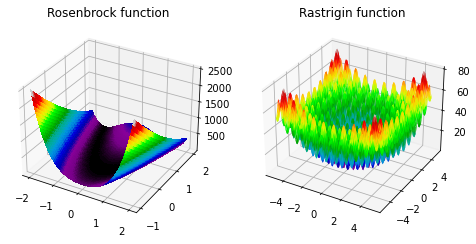

<Figure size 432x288 with 0 Axes>

In [7]:
# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=plt.figaspect(0.5))

#===============
#  First subplot
#===============
# set up the axes for the first plot
ax = fig.add_subplot(1, 2, 1, projection='3d')

X = np.linspace(-2, 2, 100)     
Y = np.linspace(-1, 2, 100)   

X, Y = np.meshgrid(X, Y)

def Rosenbrock(X):
    Z = 100.0*(X[1] - X[0]**2.0)**2.0 + (1 - X[0])**2.0
    return Z
Z =  Rosenbrock(np.array([X,Y]))

surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.nipy_spectral,linewidth=0, antialiased=False)
ax.set_title("Rosenbrock function")
#===============
# Second subplot
#===============
# set up the axes for the second plot
ax = fig.add_subplot(1, 2, 2, projection='3d')

# plot rastrigin
X = np.linspace(-5.12, 5.12, 100)     
Y = np.linspace(-5.12, 5.12, 100)     
X, Y = np.meshgrid(X, Y)

def Rastrigin(X):
    Z = (X[0]**2 - 10 * np.cos(2 * np.pi * X[0])) + (X[1]**2 - 10 * np.cos(2 * np.pi * X[1])) + 20
    return Z

Z = Rastrigin(np.array([X,Y]))

fig = plt.figure() 
surf2 = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,cmap=cm.nipy_spectral, linewidth=0.08,antialiased=True)   
ax.set_title("Rastrigin function")
plt.show()

The problem at these functions is, that we will find a local minima very fast but to find the global minima is difficult.These problems are called non-convex optimization problem.

## Gradient Methods
### Gradient Descend

### Adaptive and Momentum based optimization

### Newton and Quasi Newton Methods

## Stochastic Methods
### Random Search

### Stochastic gradient

### Cross Entropy Method



## Population Based Methods

Unlike in the previous chapter where a single point moved incrementally to the minimum, in population algorithms we have a lot of of points as start points all over the design space which are called individuals. 

### Differential Evolution

Differential evolution attempts to improve each individual in the population by recombining other individuals in the population according to a simple formula. It is parameterized by a crossover probability $p$ and a differential weight $w$. $w$ is usually between $0.4$ and $1$. For each individual $x$:

\begin{enumerate}
\item Choose three random distinct individuals $a$, $b$, and $c$.
\item Construct an interim design $z = a + w · (b − c)$
\item ...
\item ...
\item ..
\end{enumerate}


     fun: 1.9721522630525295e-31
 message: 'Optimization terminated successfully.'
    nfev: 4113
     nit: 136
 success: True
       x: array([1., 1.])
     fun: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 1773
     nit: 58
 success: True
       x: array([2.75688272e-09, 1.61125824e-09])


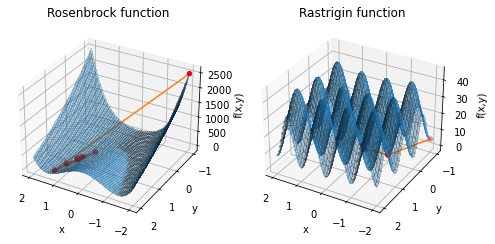

In [51]:
fig = plt.figure(figsize=plt.figaspect(0.5))
#===============
#  First subplot
#===============
# set up the axes for the first plot
ax = fig.add_subplot(1, 2, 1, projection='3d')

iters = []
start_vector = np.array([-2,-1])
start = np.append(start_vector,Rosenbrock(start_vector))
iters.append(start)
def callbackRo(Xi, convergence):
    iterations = np.append(Xi,Rosenbrock(Xi))
    iters.append(iterations)


#opt = scipy.optimize.minimize(Rosenbrock, x0=start_vector, args=(), method='CG', callback=callbackRo) #optimize using scipy implementation of truncated newton's method

bounds = [(-2,2), (-1, 2)]
opt = scipy.optimize.differential_evolution(Rosenbrock, bounds, callback=callbackRo)

iters= np.asarray(iters)
#fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
#fig2 =plt.figure("111",figsize=(12,10))
X = np.linspace(-2, 2, 100)     
Y = np.linspace(-1, 2, 100)   

X, Y = np.meshgrid(X, Y)

Z =  Rosenbrock(np.array([X,Y]))

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, linewidth=0, antialiased=False, alpha=0.3)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x,y)')
dots = ax.scatter3D(iters[:,0], iters[:,1], iters[:,2],s=20, c='r', marker='o') # ToDo add order of iterations
lines = ax.plot(iters[:,0], iters[:,1], iters[:,2]) 
ax.view_init(30, 120)
ax.set_title("Rosenbrock function")
print(opt)
#===============
# Second subplot
#===============
# set up the axes for the second plot
ax = fig.add_subplot(1, 2, 2, projection='3d')

iters = []
start_vector = np.array([-2,-1])
start = np.append(start_vector,Rastrigin(start_vector))
iters.append(start)
def callbackRa(Xi, convergence):
    iterations = np.append(Xi,Rastrigin(Xi))
    iters.append(iterations)

# opt = scipy.optimize.minimize(Rastrigin, x0=start_vector, args=(), method='CG', callback=callbackR) #optimize using scipy implementation of truncated newton's method
bounds = [(-2,2), (-1, 2)]
opt = scipy.optimize.differential_evolution(Rastrigin, bounds, callback=callbackRa)

iters= np.asarray(iters)

X = np.linspace(-2, 2, 100)     
Y = np.linspace(-1, 2, 100)   

X, Y = np.meshgrid(X, Y)

Z =  Rastrigin(np.array([X,Y]))

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, linewidth=0, antialiased=False, alpha=0.3)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x,y)')
dots = ax.scatter3D(iters[:,0], iters[:,1], iters[:,2],s=20, c='r', marker='o') # ToDo add order of iterations
lines = ax.plot(iters[:,0], iters[:,1], iters[:,2]) 
ax.view_init(30, 120)   
ax.set_title("Rastrigin function")
print(opt)
plt.show()

Particle Swarm Optimization


## References

```{bibliography}
:filter: docname in docnames
:style: plain
```